In [3]:
from datetime import datetime, timedelta, time as dtime
import pandas as pd
import pytz
from kiteconnect import KiteConnect
import time
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import logging
from kiteconnect import KiteConnect

logging.basicConfig(level=logging.DEBUG)

In [6]:
kite = KiteConnect(api_key=('o2bikhb0e69hvnhk'))

In [7]:
kite.login_url()

'https://kite.zerodha.com/connect/login?api_key=o2bikhb0e69hvnhk&v=3'

In [8]:
data = kite.generate_session('vFi4Puow4qyiC4JOohiwT99CE7hDmBx0', api_secret='avcts2er4x6d9jlk6ls2nblf9b5c8l5o')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.kite.trade:443
DEBUG:urllib3.connectionpool:https://api.kite.trade:443 "POST /session/token HTTP/11" 200 None


In [9]:
kite.set_access_token(data["access_token"])

# Builder starts here. 

In [37]:
instrument_token = 13678850 
interval = "15minute"
days = 200

In [38]:
india = pytz.timezone("Asia/Kolkata")
to_date = datetime.now(india)
from_date = to_date - timedelta(days=days)

records = kite.historical_data(instrument_token, from_date, to_date, interval)


DEBUG:urllib3.connectionpool:Resetting dropped connection: api.kite.trade
DEBUG:urllib3.connectionpool:https://api.kite.trade:443 "GET /instruments/historical/13678850/15minute?from=2025-01-03+15%3A23%3A57&to=2025-07-22+15%3A23%3A57&interval=15minute&continuous=0&oi=0 HTTP/11" 200 None


In [39]:
data = pd.DataFrame(records)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


✅ Data prepared successfully.
✅ Indicators calculated manually, including ATR.
✅ Trading signals generated. Found 10 total signals.

✅ Backtest complete. Analyzing results...

--- 📈 BACKTEST RESULTS ---
Ending Capital: ₹100,161.00
Total PnL: ₹161.00
Win Rate: 44.44%
Total Trades: 9


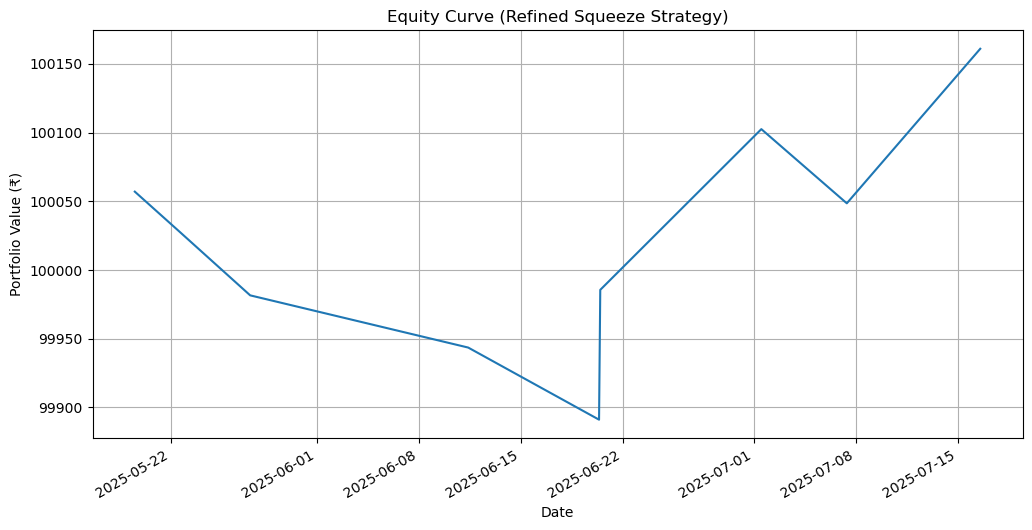

In [42]:
# --- 1. Prepare Your Data ---
# (Your existing code for fetching and preparing the 'data' DataFrame goes here)
# For example:
# data = pd.DataFrame(records)
# data['date'] = pd.to_datetime(data['date'])
# data.set_index('date', inplace=True)

print("✅ Data prepared successfully.")


# --- 2. Manual Indicator Calculations ---
bb_window = 20
bb_std = 2.0
keltner_window = 20
keltner_atr_mult = 1.5
adx_period = 14
atr_period = 14 # For our risk management

def calculate_indicators(df):
    # Bollinger Bands
    df['BBM'] = df['close'].rolling(window=bb_window).mean()
    std = df['close'].rolling(window=bb_window).std()
    df['BBU'] = df['BBM'] + (std * bb_std)
    df['BBL'] = df['BBM'] - (std * bb_std)

    # --- ATR Calculation (for Keltner and Risk Management) ---
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift(1))
    low_close = np.abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.ewm(alpha=1/atr_period, adjust=False).mean() # <-- ATR IS NOW CALCULATED

    # Keltner Channels
    df['KCM'] = df['close'].ewm(span=keltner_window, adjust=False).mean()
    df['KCU'] = df['KCM'] + (df['ATR'] * keltner_atr_mult)
    df['KCL'] = df['KCM'] - (df['ATR'] * keltner_atr_mult)

    # ADX
    df['up_move'] = df['high'].diff()
    df['down_move'] = df['low'].diff().mul(-1)
    df['+DM'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['-DM'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    plus_di_smooth = pd.Series(df['+DM']).ewm(alpha=1/adx_period, adjust=False).mean()
    minus_di_smooth = pd.Series(df['-DM']).ewm(alpha=1/adx_period, adjust=False).mean()
    df['DMP'] = 100 * (plus_di_smooth / df['ATR'])
    df['DMN'] = 100 * (minus_di_smooth / df['ATR'])
    dx = 100 * (np.abs(df['DMP'] - df['DMN']) / (df['DMP'] + df['DMN']))
    df['ADX'] = dx.ewm(alpha=1/adx_period, adjust=False).mean()
    
    df.drop(columns=['up_move', 'down_move', '+DM', '-DM'], inplace=True)
    return df

data = calculate_indicators(data)
data.dropna(inplace=True)
print("✅ Indicators calculated manually, including ATR.")


# --- 3. Define the Trading Signals ---
# (This section remains unchanged)
data['squeeze_on'] = (data['BBL'] > data['KCL']) & (data['BBU'] < data['KCU'])
data['squeeze_release'] = (data['squeeze_on'].shift(1) & ~data['squeeze_on'])
adx_threshold = 20 # Lowering threshold for testing
data['adx_strong'] = data['ADX'] > adx_threshold
data['long_breakout'] = data['close'] > data['BBU']
data['short_breakout'] = data['close'] < data['BBL']

long_signal = data['squeeze_release'] & data['adx_strong'] & data['long_breakout']
short_signal = data['squeeze_release'] & data['adx_strong'] & data['short_breakout']

data['signal'] = 0
data.loc[long_signal, 'signal'] = 1
data.loc[short_signal, 'signal'] = -1
print(f"✅ Trading signals generated. Found {len(data[data['signal'] != 0])} total signals.")


# --- 4. Run the Backtest with Dynamic ATR Exits ---
initial_capital = 100000.0
trades = []
in_position = False

for i in range(1, len(data)):
    if not in_position and data['signal'].iloc[i] != 0:
        entry_price = data['close'].iloc[i]
        atr_value = data['ATR'].iloc[i]
        
        if data['signal'].iloc[i] == 1: # Go Long
            stop_loss = entry_price - (atr_value * 2)    # Stop loss is 2x ATR below entry
            take_profit = entry_price + (atr_value * 4)  # Take profit is 4x ATR above entry
            trade_type = 'long'
        else: # Go Short
            stop_loss = entry_price + (atr_value * 2)    # Stop loss is 2x ATR above entry
            take_profit = entry_price - (atr_value * 4)  # Take profit is 4x ATR below entry
            trade_type = 'short'
            
        trades.append({'type': trade_type, 'entry_price': entry_price, 'entry_date': data.index[i], 'sl': stop_loss, 'tp': take_profit})
        in_position = True

    # (The rest of the exit logic and analysis code remains the same)
    if in_position:
        current_price = data['close'].iloc[i]
        last_trade = trades[-1]
        if 'exit_price' in last_trade: continue

        if last_trade['type'] == 'long':
            if current_price <= last_trade['sl'] or current_price >= last_trade['tp']:
                last_trade.update({'exit_price': current_price, 'exit_date': data.index[i]})
                in_position = False
        elif last_trade['type'] == 'short':
            if current_price >= last_trade['sl'] or current_price <= last_trade['tp']:
                last_trade.update({'exit_price': current_price, 'exit_date': data.index[i]})
                in_position = False

# --- 5. Analyze the Results ---
print("\n✅ Backtest complete. Analyzing results...")
if trades and 'exit_price' in trades[-1]:
    trades_df = pd.DataFrame(trades)
    trades_df['pnl'] = np.where(trades_df['type'] == 'long', trades_df['exit_price'] - trades_df['entry_price'], trades_df['entry_price'] - trades_df['exit_price'])
    position_size = 10
    trades_df['pnl_rupees'] = trades_df['pnl'] * position_size
    total_pnl = trades_df['pnl_rupees'].sum()
    win_rate = (trades_df['pnl'] > 0).mean() * 100
    
    print("\n--- 📈 BACKTEST RESULTS ---")
    print(f"Ending Capital: ₹{initial_capital + total_pnl:,.2f}")
    print(f"Total PnL: ₹{total_pnl:,.2f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total Trades: {len(trades_df)}")

    trades_df['equity_curve'] = initial_capital + trades_df['pnl_rupees'].cumsum()
    trades_df.set_index(pd.to_datetime(trades_df['exit_date']), inplace=True)
    trades_df['equity_curve'].plot(title='Equity Curve (Refined Squeeze Strategy)', figsize=(12, 6))
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (₹)')
    plt.grid(True)
    plt.show()
else:
    print("\n⚠️ No trades were completed during the backtest period.")

# BUILDER

In [43]:
# --- 1. Prepare Your Data ---
data = pd.DataFrame(records)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
print("✅ Data prepared successfully.")

✅ Data prepared successfully.


In [44]:
# --- 2. Calculate Indicators Manually ---

# Function to calculate Bollinger Bands
def calculate_bbands(df, length=20, std_dev=2.0):
    # Middle Band = 20-period SMA
    df['BBM'] = df['close'].rolling(window=length).mean()
    # Standard Deviation
    std = df['close'].rolling(window=length).std()
    # Upper and Lower Bands
    df['BBU'] = df['BBM'] + (std * std_dev)
    df['BBL'] = df['BBM'] - (std * std_dev)
    return df

# Function to calculate Keltner Channels
def calculate_kc(df, ema_length=20, atr_length=10, atr_multiplier=2.0):
    # Calculate True Range (TR)
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift(1))
    low_close = np.abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    # Calculate Average True Range (ATR)
    atr = tr.ewm(alpha=1/atr_length, adjust=False).mean()
    # Keltner Channel Middle, Upper, Lower
    df['KCM'] = df['close'].ewm(span=ema_length, adjust=False).mean()
    df['KCU'] = df['KCM'] + (atr * atr_multiplier)
    df['KCL'] = df['KCM'] - (atr * atr_multiplier)
    return df

# Function to calculate Average Directional Index (ADX)
def calculate_adx(df, length=14):
    # Calculate Directional Movement (+DM, -DM)
    df['up_move'] = df['high'].diff()
    df['down_move'] = df['low'].diff().mul(-1)
    df['+DM'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['-DM'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    
    # Calculate Smoothed True Range, +DM, -DM
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift(1))
    low_close = np.abs(df['low'] - df['close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    atr = tr.ewm(alpha=1/length, adjust=False).mean()
    plus_di_smooth = pd.Series(df['+DM']).ewm(alpha=1/length, adjust=False).mean()
    minus_di_smooth = pd.Series(df['-DM']).ewm(alpha=1/length, adjust=False).mean()
    
    # Calculate Directional Indicators (+DI, -DI)
    df['DMP'] = 100 * (plus_di_smooth / atr)
    df['DMN'] = 100 * (minus_di_smooth / atr)
    
    # Calculate DX and ADX
    dx = 100 * (np.abs(df['DMP'] - df['DMN']) / (df['DMP'] + df['DMN']))
    df['ADX'] = dx.ewm(alpha=1/length, adjust=False).mean()
    return df.drop(columns=['up_move', 'down_move', '+DM', '-DM'])

# Apply all indicator calculations
data = calculate_bbands(data)
data = calculate_kc(data)
data = calculate_adx(data)
data.dropna(inplace=True)

print("✅ Indicators calculated manually.")

✅ Indicators calculated manually.


In [45]:
# --- 3. Define the Trading Signals ---
squeeze_on = (data['BBL'] > data['KCL']) & (data['BBU'] < data['KCU'])
squeeze_off = (data['BBL'] < data['KCL']) & (data['BBU'] > data['KCU'])
long_signal = (squeeze_off.shift(1) & squeeze_on) & (data['ADX'] > 25) & (data['DMP'] > data['DMN'])
short_signal = (squeeze_off.shift(1) & squeeze_on) & (data['ADX'] > 25) & (data['DMN'] > data['DMP'])

data['signal'] = 0
data.loc[long_signal, 'signal'] = 1
data.loc[short_signal, 'signal'] = -1
print(f"✅ Trading signals generated. Found {len(data[data['signal'] != 0])} total signals.")


✅ Trading signals generated. Found 1 total signals.


In [46]:
# --- 4. Run the Backtest ---
initial_capital = 50000.0
reward_risk_ratio = 1.0
stop_loss_pct = 0.02
trades = []
in_position = False

for i in range(1, len(data)):
    if not in_position and data['signal'].iloc[i] != 0:
        entry_price = data['close'].iloc[i]
        trade_type = 'long' if data['signal'].iloc[i] == 1 else 'short'
        stop_loss = entry_price * (1 - stop_loss_pct) if trade_type == 'long' else entry_price * (1 + stop_loss_pct)
        take_profit = entry_price + (entry_price - stop_loss) * reward_risk_ratio if trade_type == 'long' else entry_price - (stop_loss - entry_price) * reward_risk_ratio
        trades.append({'type': trade_type, 'entry_price': entry_price, 'entry_date': data.index[i], 'sl': stop_loss, 'tp': take_profit})
        in_position = True

    if in_position:
        current_price = data['close'].iloc[i]
        last_trade = trades[-1]
        if 'exit_price' in last_trade: continue

        if last_trade['type'] == 'long' and (current_price <= last_trade['sl'] or current_price >= last_trade['tp']):
            last_trade.update({'exit_price': current_price, 'exit_date': data.index[i]})
            in_position = False
        elif last_trade['type'] == 'short' and (current_price >= last_trade['sl'] or current_price <= last_trade['tp']):
            last_trade.update({'exit_price': current_price, 'exit_date': data.index[i]})
            in_position = False

if in_position and 'exit_price' not in trades[-1]:
    trades[-1].update({'exit_price': data['close'].iloc[-1], 'exit_date': data.index[-1]})


✅ Backtest complete. Analyzing results...

--- 📈 BACKTEST RESULTS ---
Ending Capital: ₹50,185.00
Total PnL: ₹185.00
Win Rate: 100.00%
Total Trades: 1


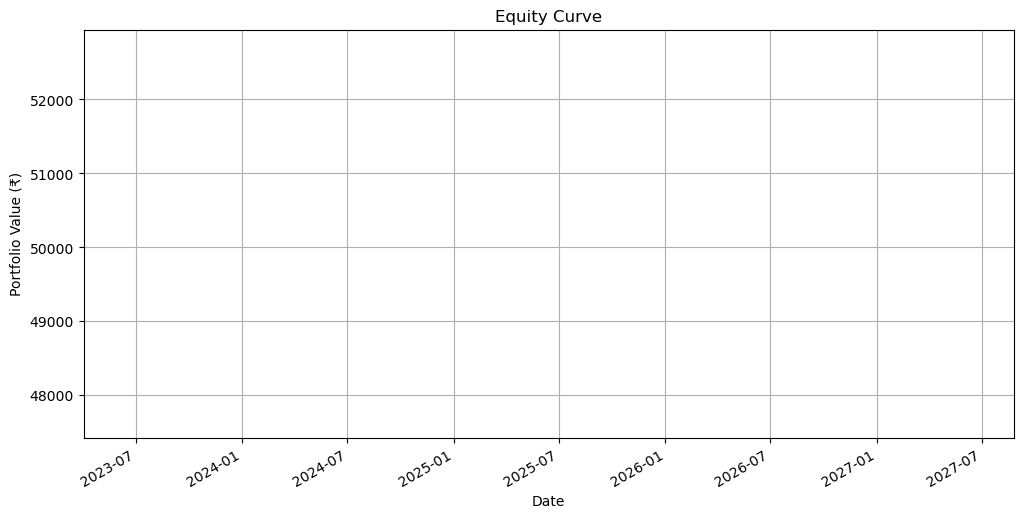

In [47]:
# --- 5. Analyze the Results ---
print("\n✅ Backtest complete. Analyzing results...")

if trades and 'exit_price' in trades[-1]:
    trades_df = pd.DataFrame(trades)
    trades_df['pnl'] = np.where(trades_df['type'] == 'long', trades_df['exit_price'] - trades_df['entry_price'], trades_df['entry_price'] - trades_df['exit_price'])
    position_size = 10
    trades_df['pnl_rupees'] = trades_df['pnl'] * position_size
    
    total_pnl = trades_df['pnl_rupees'].sum()
    win_rate = (trades_df['pnl'] > 0).mean() * 100
    
    print("\n--- 📈 BACKTEST RESULTS ---")
    print(f"Ending Capital: ₹{initial_capital + total_pnl:,.2f}")
    print(f"Total PnL: ₹{total_pnl:,.2f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total Trades: {len(trades_df)}")

    trades_df['equity_curve'] = initial_capital + trades_df['pnl_rupees'].cumsum()
    trades_df.set_index(pd.to_datetime(trades_df['exit_date']), inplace=True)
    trades_df['equity_curve'].plot(title='Equity Curve', figsize=(12, 6))
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value (₹)')
    plt.grid(True)
    plt.show()
else:
    print("\n⚠️ No trades were completed during the backtest period.")